# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
# PyTorch
from torchvision import transforms #to do transformations
from torchvision import datasets #to create a datasets 
from torch.utils.data import DataLoader # to create a dataloder DataLoaders 
from torchvision import models # Loading in a pre-trained model in PyTorch VGG-16
import torch
from torch import optim, cuda
from torch import nn
import torch.nn.functional as F

# Data science tools
import numpy as np
import os # to open the files 
import pandas as pd # to create the history of loss and accuracy dataframe

# Image manipulations
from PIL import Image

import json # to load the json file


# Timing utility
from timeit import default_timer as timer # to calculate the spended time

# Visualizations
import matplotlib.pyplot as plt # to plot the images 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['font.size'] = 14

###  Parameters 
We define the global paremeters here so to change them anytime whithout interfer the code

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

save_file_name = 'image_classifier.pt' # to save the sessions during the training phase
checkpoint_path = 'image_classifier.pth' # to save the model parameters

batch_size = 64 

# Whether to train on a gpu
train_on_gpu = cuda.is_available() # check the existance of Gpu unit
print(f'Train on gpu: {train_on_gpu}')


Train on gpu: True


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
# Done: Define your transforms for the training, validation, and testing sets
# Image transformations
data_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 64

# Done: Load the datasets with ImageFolder
image_datasets =  {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}

# Done: Using the image datasets and the trainforms, define the dataloaders
# Data iterators
dataloaders ={x: DataLoader(image_datasets[x], batch_size = batch_size,
                                             shuffle=True)
              for x in ['train', 'valid', 'test']}


In [4]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape
n_classes = len(dataloaders['train'].dataset.classes)

validiter = iter(dataloaders['valid'])
next(validiter)[0].shape


torch.Size([64, 3, 224, 224])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

list(cat_to_name.items())[:10]

[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster'),
 ('27', 'prince of wales feathers'),
 ('7', 'moon orchid'),
 ('16', 'globe-flower'),
 ('25', 'grape hyacinth'),
 ('26', 'corn poppy')]

In [6]:
#Mapping classes to Indexes
class_to_idx = image_datasets['train'].class_to_idx
idx_to_name = {
    idx: cat_to_name[class_]
    for class_, idx in image_datasets['train'].class_to_idx.items()
}

list(idx_to_name.items())[:10]

[(0, 'pink primrose'),
 (1, 'globe thistle'),
 (2, 'blanket flower'),
 (3, 'trumpet creeper'),
 (4, 'blackberry lily'),
 (5, 'snapdragon'),
 (6, "colt's foot"),
 (7, 'king protea'),
 (8, 'spear thistle'),
 (9, 'yellow iris')]

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

# Pre-Trained Models for Image Recognition
We will use VGG-16 as pretained model 
This model has over 130 million parameters, but in our case we will train only the very last few fully-connected layers. So as first step, we freeze all of the model’s weights.
After we add our custom calssifier

In [7]:
#Loading in a pre-trained model
model = models.vgg16(pretrained=True)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

model.classifier[6]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 57591586.11it/s]


Linear(in_features=4096, out_features=1000, bias=True)

In [8]:
# Classifier 
class Sequential_Network(nn.Module):
    def __init__(self, n_inputs, n_classes, drop_prob=0.4):
        super(Sequential, self).__init__()
        # Define the fully connected layers
        self.fc1 = nn.Linear(n_inputs, int(n_inputs / 4))
        self.fc2 = nn.Linear(int(n_inputs / 4), int(n_inputs / 8))
        self.fc3 = nn.Linear(int(n_inputs / 8), n_classes)
        
        # Define Dropout Function
        self.dropout = nn.Dropout(p=drop_prob)
        
        # The Output layer
        self.out = nn.LogSoftmax(dim = 1)
    
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = self.fc1(x)
        # Apply the activation function for the first layer
        x = F.relu(x)
        # Apply dorpout for the frist layer 
        x = self.dropout(x)
        # Apply the same process for the other layers 
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.out(x)  
        return x

In [9]:
n_inputs = model.classifier[6].in_features # get the number of inputs from the last layer of VGG
n_classes = len(dataloaders['train'].dataset.classes) # get the number of classes => the number of categories of train dataset


model.classifier[6] = nn.Linear(n_inputs, n_classes)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)

In [10]:
# TODO: Build and train your network
if train_on_gpu:
    model = model.to('cuda')

In [11]:
# Implement a function for the validation pass
def validation(model, valid_loader, criterion):
    valid_loss = 0
    valid_acc = 0
    for images, labels in valid_loader:
         # Tensors to gpu
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Forward pass    
        output = model(images)
        # Validation loss
        loss = criterion(output, labels)
        # Multiply average loss times the number of examples in batch
        valid_loss += loss.item() * images.size(0)
        
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * images.size(0)
    
    return valid_loss, valid_acc

In [12]:
def train_model(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          epochs_stop=3,
          epochs=20,
          print_every=10):
    '''
        The role of this function is to train the model 
        
        Params: 
            model: Pytorch model, the model to train 
            criterion: Pytorch loss, the loss function 
            optimizer: PyTorch optimizier, the optimizer to use to calculare the gradient decenet 
            train_loader: PyTorch dataloader, the training data loader to iterate through
            valid_loader: PyTorch dataloader, the dataset used for validation 
            save_file_name: String ending with '.pt' extenstion, the file to save the model state dictionary 
            epoches_stop: int, the maximun number of epoches to stop from after no improvement 
            epoches: int, the number of epoches for training 
            print_every: int, frequency of epochs to print training stats
            
        Returns: 
            model: Pytorch model, the trained model 
            history: DataFrame, history of train and validation loss & accuracy
    '''
    
    history = [] # to store the history here 
    valid_max_acc = 0
    # Early stopping Initialization
    epochs_without_improve = 0
    valid_loss_min = np.Inf
    
    # Number of epochs already trained in case we use the loaded model 
    try:
        print("The number of epochs the model has trained for were => {} ".format(model.epochs))
    except:
        model.epochs = 0
        print('Start Training from Scratch.\n')

    overall_start = timer() # to calculate the overall time
    
    for epoch in range(epochs):
        
        # Keep track of training & validation loss and accuracy
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0 
        valid_acc = 0 
        
        model.train()
        
        start = timer() # to caculate the consumed time for every epoch
        for images, labels in iter(train_loader):
            
            # move to gpu 
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            
            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()
            # Forward pass, then backward pass, then update weights
            output = model(images)
            
            # Loss and backpropagation of gradients
            loss = criterion(output, labels)
            loss.backward()
    
            # Update the parameters
            optimizer.step()
            
            # Track train loss
            train_loss += loss.item() * images.size(0)
            
            # Calculate the accuracy
            _, pred = torch.max(output, dim = 1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
    
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * images.size(0) 
            
        # Here we use the else block just after for/while loop to execute it only 
        #hen the loop is NOT terminated by a break statement
        else: 
            # Increase the number of epochs after each statement
            model.epochs += 1
            # Make sure network is in eval mode for inference
            model.eval()
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                ## Run validation after every epoch : 
                valid_loss, valid_acc = validation(model, valid_loader, criterion)
                
                # Calculate mean losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)


                # Calculate mean accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                
                history.append([train_loss, valid_loss, train_acc, valid_acc])
                
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                      "Training Loss: {:.3f}.. ".format(train_loss),
                      "Valid Loss: {:.3f}.. ".format(valid_loss),
                      "Train Accuracy: {:.2f}%".format(100 * train_acc),
                      "Valid Accuracy: {:.2f}%".format( 100 * valid_acc))
                    
                # Early stopping based on the max number of epoches witout improvement
                # Save the model if the validation and the loss decreases
                if valid_loss < valid_loss_min - 0.01:
                    print('Validation loss decreased ({:.4f} => {:.4f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                    
                    # Save the model
                    torch.save(model.state_dict(), save_file_name)
                    epochs_without_improve = 0
                    valid_loss_min = valid_loss
                # Else increment the number of epoches without improvement
                else:
                    epochs_without_improve += 1
                    print('Number of epoches without improvement: {}'.format(epochs_without_improve))
                    if epochs_without_improve >= epochs_stop:
                        print('Early Stopping')
                        total_time = timer() - overall_start
                        print('Total time: {:.2f} seconds.Time/epoch: {:.2f} seconds'.format(total_time,
                                                                                     total_time / (epoch+1)))
                        # Load the best state dictionary
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer
                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history
                    
    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print("Total time: {:.2f} seconds. Time per epoche was {:.2f} seconds".format(total_time,
                                                                          total_time / epoch ))
    # Format the history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history       

In [14]:
#Load the model if exist 
#model, _ = load_checkpoint(checkpoint_path, models.vgg16(pretrained=True))

#define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))

# Train the model 
model, history = train_model(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    epochs_stop=5,
    epochs=30,
    print_every=2)

Start Training from Scratch.

Validation loss decreased (inf => 1.0560).  Saving model ...
Epoch: 2/30..  Training Loss: 0.934..  Valid Loss: 0.804..  Train Accuracy: 76.21% Valid Accuracy: 80.32%
Validation loss decreased (1.0560 => 0.8040).  Saving model ...
Validation loss decreased (0.8040 => 0.6995).  Saving model ...
Epoch: 4/30..  Training Loss: 0.659..  Valid Loss: 0.671..  Train Accuracy: 81.82% Valid Accuracy: 83.74%
Validation loss decreased (0.6995 => 0.6713).  Saving model ...
Validation loss decreased (0.6713 => 0.6331).  Saving model ...
Epoch: 6/30..  Training Loss: 0.541..  Valid Loss: 0.607..  Train Accuracy: 84.54% Valid Accuracy: 84.11%
Validation loss decreased (0.6331 => 0.6070).  Saving model ...
Validation loss decreased (0.6070 => 0.5675).  Saving model ...
Epoch: 8/30..  Training Loss: 0.490..  Valid Loss: 0.559..  Train Accuracy: 85.26% Valid Accuracy: 84.72%
Number of epoches without improvement: 1
Validation loss decreased (0.5675 => 0.5446).  Saving model 

Text(0.5,1,'Training and Validation Accuracy')

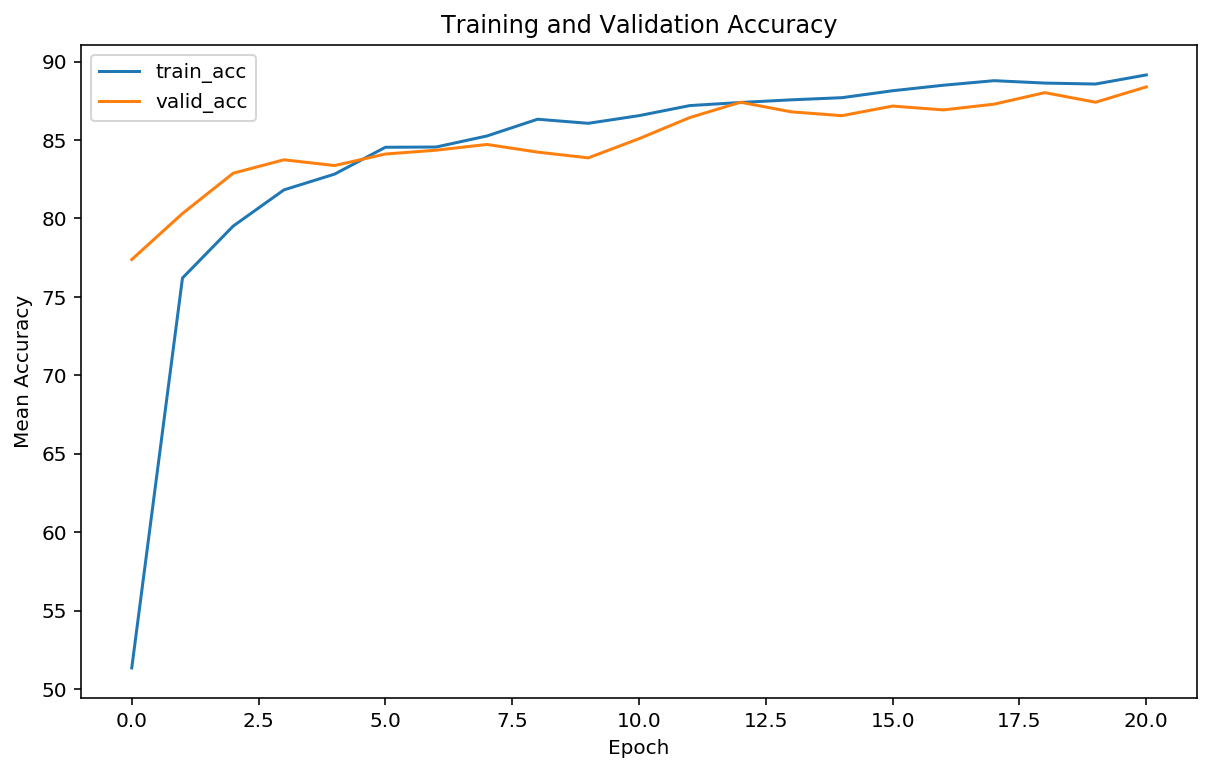

In [15]:
plt.figure(figsize=(10, 6))
for acc in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[acc], label=acc)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Accuracy')
plt.title('Training and Validation Accuracy')

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Do validation on the test set

# Make sure network is in eval mode for inference
model.eval()
# Turn off gradients for validation, saves memory and computations
with torch.no_grad(): 
    ## Test the model  
    test_loss, test_acc = validation(model, dataloaders['test'], criterion)
# Calculate mean losses
test_loss = test_loss / len(dataloaders['test'].dataset)
# Calculate mean accuracy
test_acc = test_acc / len(dataloaders['test'].dataset)  
    
print("Test Loss: {:.3f}.. ".format(test_loss),"Test Accuracy: {:.2f}%".format( 100 * test_acc))

Test Loss: 0.562..  Test Accuracy: 85.35%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint 
def save_checkpoint(model, optimizer, path, cat_to_name, idx_to_name):
    checkpoint = {
        'cat_to_name': cat_to_name,
        'class_to_idx': image_datasets['train'].class_to_idx,
        'idx_to_name': idx_to_name,
        'epochs': model.epochs,
        'classifier': model.classifier,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    
    torch.save(checkpoint, path)
    
save_checkpoint(model, optimizer, checkpoint_path, cat_to_name, idx_to_name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath, model,):
    
    # Set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False
        
    # Load the saved file    
    checkpoint = torch.load(filepath)
    
    # Rebuild the model
    model.classifier = checkpoint['classifier']
    model.cat_to_name = checkpoint['cat_to_name']
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_name = checkpoint['idx_to_name']
    model.epochs = checkpoint['epochs']
    
    # Load the state dict with torch.load 
    model.load_state_dict(checkpoint['state_dict'])
    
    # Move to gpu 
    if train_on_gpu:
        model = model.to('cuda')
        
    # Load the optimiser in our case we used Adam optimiser 
    optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

model, optimizer = load_checkpoint(checkpoint_path , models.vgg16(pretrained=True))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Done: Process a PIL image for use in a PyTorch model
    
    image = Image.open(image_path)
    # Resize the images where the shortest side is 256 pixels using resize method 
    img = image.resize((256, 256))
    
    # Crop out the center 224x224 portion of the image using crop method
    width = 256 
    height = 256
    new_width = 224
    new_height = 224
    
    # Setting the points for cropped image 
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    
    # Cropped image of above dimension 
    img = img.crop((left, top, right, bottom))
       
    # Convert to numpy
    img = np.array(img)
    # Reorder the dimension of the color to the first position using ndarray.transpose and retain the order of the other dimension
    img = img.transpose((2, 0, 1)) 
    # Normalize the image 
    img = img / 256
    
    # Standardize the Image 
    # Define the mean which is [0.485, 0.456, 0.406] 
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    # Define the standar deviation which is  [0.229, 0.224, 0.225]
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    # Subtract the means from each color channel, then divide by the standard deviation
    img = (img - means) / stds

    #Convert the image to pytorch tensor
    img_tensor = torch.Tensor(img)
    
    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax, image

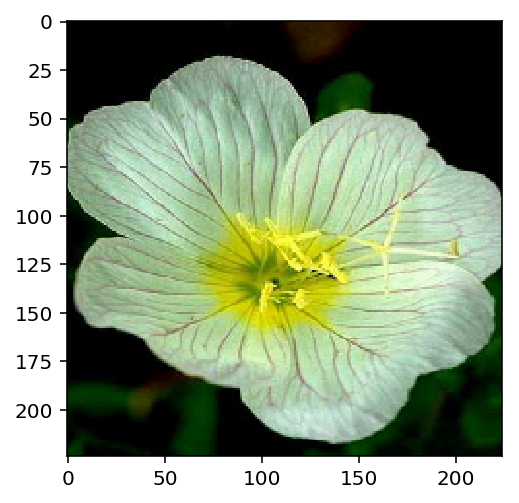

In [21]:
img = process_image('flowers/valid/1/image_06739.jpg')
ax, image = imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Done: Implement the code to predict the class from an image file
    
    # Convert the image to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize the image tensore 
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Evaluation
    with torch.no_grad():
        
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        
        ps = torch.exp(out)
        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_name[category] for category in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]
        
        return top_p, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [23]:
def display_prediction(image_path, topk=5):
    # Open the image to show it in the first column of the plot 
    image = Image.open(image_path)   
    #predict topk classes 
    top_probs, top_classes = predict(image_path, model, topk)   
    # Get the top class that have the max probat
    top_p = top_probs[np.argmax(top_probs)] # the top class proba
    top_c = top_classes[np.argmax(top_probs)] # top class label    
    # Create the figure 
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)    
    # Plot the image in the first axe with it's category name
    ax1.axis('off')
    ax1.set_title(top_c)
    ax1.imshow(image) 
    # Create the second plot 
    #Set the lables of y-awes of the second plot 
    labels = []
    for classe in top_classes:
        labels.append(classe)
    y_pos = np.arange(topk)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()  # probabilities read top-to-bottom
    ax2.barh(y_pos, top_probs, xerr=0, align='center')

    plt.show() # show the plot
    

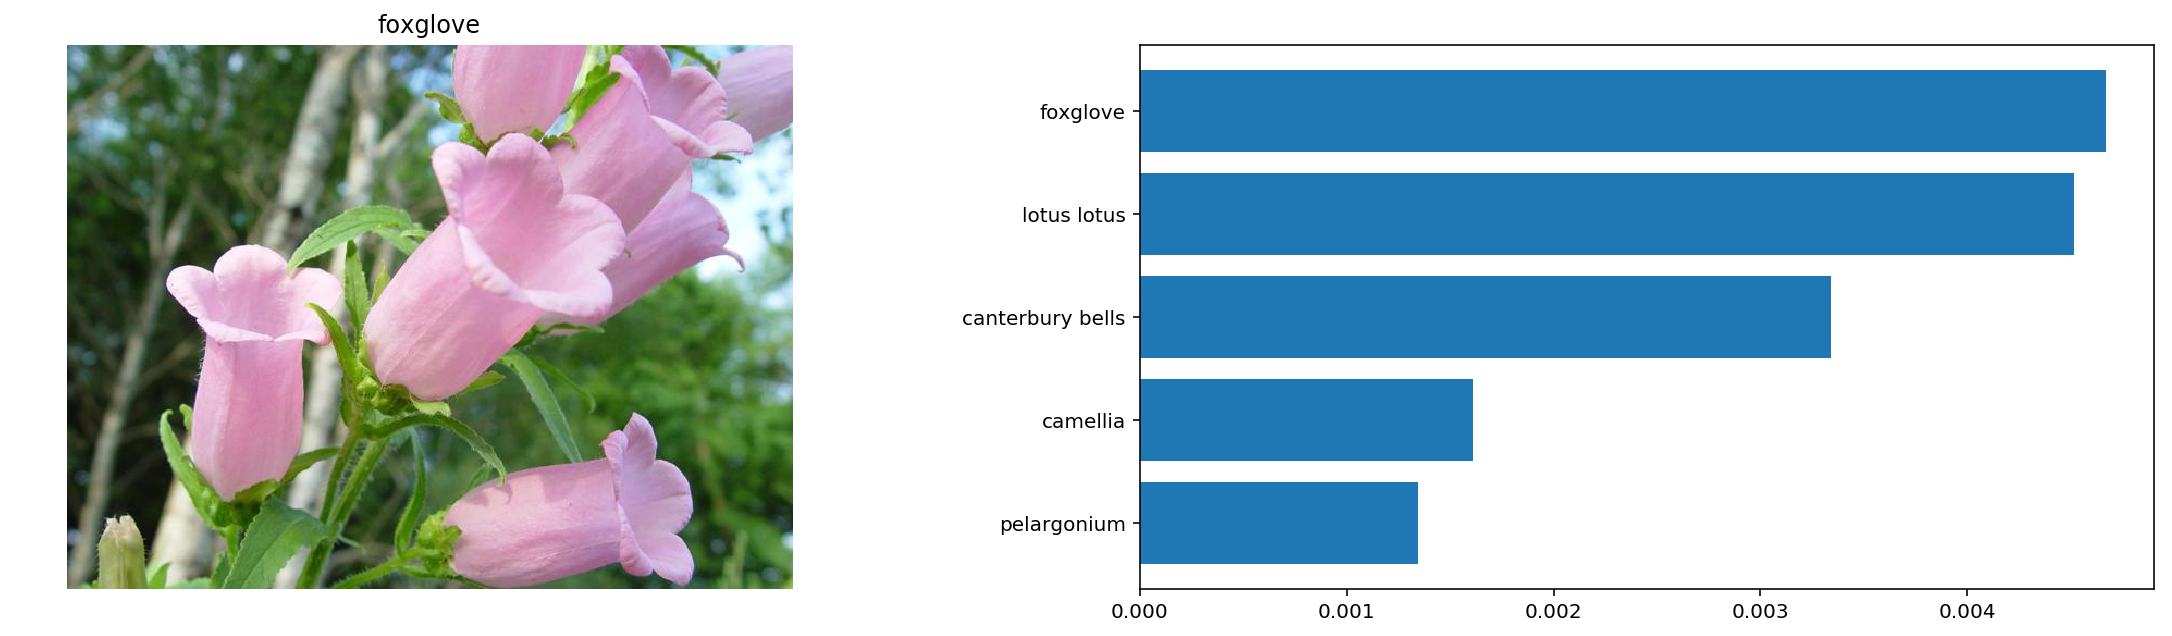

In [24]:
ex_image = 'flowers/test/3/image_06634.jpg'
display_prediction(ex_image, topk=5)